In [1]:
import sys
import os

# Add the simulations/mcpy directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../simulations')))

import numpy as np
import pandas as pd

import ivfunctions_nested 
import simulations.dgps_nested as dgps
import matplotlib.pyplot as plt

from nnpiv.ensemble import EnsembleIV, EnsembleIVL2, Ensemble2IV, Ensemble2IVL2
 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
fn_number = 8
tau_fn = dgps.get_tau_fn(fn_number)

In [3]:
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)


B_test = np.zeros((1000, B.shape[1]))
B_test += np.median(B, axis=0, keepdims=True)
B_test[:, 0] = np.linspace(np.percentile(B[:, 0], 5), np.percentile(B[:, 0], 95), 1000)

B_test = B_test[np.argsort(B_test[:, 0])]
true_fn = tau_fn(B_test)


In [4]:
def nested_npivfit(A, B, C, D, Y, B_test, model, fitargs=None):
    
    B1_test = B_test
    Y = Y
    A1 = A
    B1 = B
    A2 = D
    B2 = C

    #First stage
    if fitargs is not None:
        model.fit(A2, A1, Y, **fitargs)
    else:
        model.fit(A2, A1, Y)
    bridge_fs = model.predict(A1)
    bridge_fs = bridge_fs.reshape(A1.shape[:1] + Y.shape[1:])

    #Second stage
    if fitargs is not None:
        model.fit(B2, B1, bridge_fs, **fitargs)
    else:
        model.fit(B2, B1, bridge_fs)
    
    y_pred = model.predict(B1_test)
    return y_pred.reshape(B1_test.shape[:1] + Y.shape[1:])





In [6]:
rfiv_model = EnsembleIV(n_iter=200, max_abs_value=2)
rfiv_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rfiv_model)
 

In [8]:
adversary = RandomForestRegressor(n_estimators=40, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)

learnerh =  RandomForestRegressor(n_estimators=40, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)

rfivl2_model = EnsembleIVL2(n_iter=400, adversary=adversary, learner=learnerh)

#rfivl2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=rfivl2_model)

In [9]:
adversary = RandomForestRegressor(n_estimators=40, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerg = RandomForestClassifier(n_estimators=5, max_depth=2, criterion='gini',
                                    bootstrap=False, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerh = RandomForestClassifier(n_estimators=5, max_depth=2, criterion='gini',
                                    bootstrap=False, min_samples_leaf=40, min_impurity_decrease=0.001)

rfiv2_model = Ensemble2IV(n_iter=400, max_abs_value=2, adversary=adversary, learnerg=learnerg, learnerh=learnerh, n_burn_in=10)

#rfiv2_model = Ensemble2IV(n_iter=200, max_abs_value=4)
rfiv2_pred = rfiv2_model.fit(A, B, C, D, Y).predict(B_test)

In [10]:
adversary = RandomForestRegressor(n_estimators=40, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerg = RandomForestRegressor(n_estimators=40, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)
learnerh =  RandomForestRegressor(n_estimators=40, max_depth=2,
                                    bootstrap=True, min_samples_leaf=40, min_impurity_decrease=0.001)


rfiv2l2_model = Ensemble2IVL2(n_iter=400, adversary=adversary, learnerg=learnerg, learnerh=learnerh, n_burn_in=10)

#rfiv2l2_pred = rfiv2l2_model.fit(A, B, C, D, Y).predict(B_test)

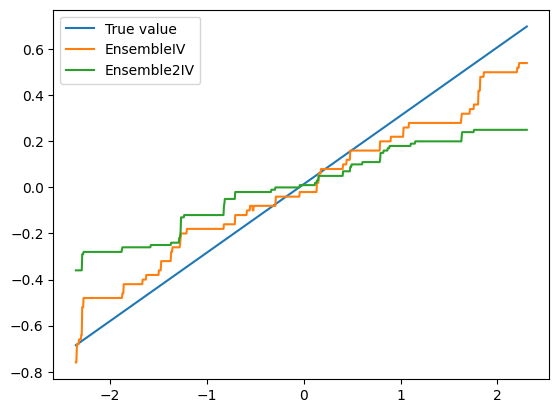

In [11]:
plt.plot(B_test[:, 0], true_fn, label='True value')
plt.plot(B_test[:, 0], rfiv_pred, label='EnsembleIV')
#plt.plot(B_test[:, 0], rfivl2_pred, label='EnsembleIVL2')
plt.plot(B_test[:, 0], rfiv2_pred, label='Ensemble2IV')
#plt.plot(B_test[:, 0], rfiv2l2_pred, label='Ensemble2IVL2')
plt.legend()
